In [2]:
import numpy as np
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import torch
import torch.nn as nn
import torch.optim as optim
from operator import truediv
import h5py
import time
import SSFTTnet
import argparse


import torch.utils.data as Data
import torch.backends.cudnn as cudnn


from auxiliary_classifier import auxiliary_test_epoch
from auxiliary_classifier import auxiliary_train_epoch
from auxiliary_classifier import auxiliary_valid_epoch

from data_prepare import mirror_hsi
from data_prepare import choose_train_and_test_number
from data_prepare import choose_train_and_test_proportion
from data_prepare import train_and_test_data, train_and_test_label

from Utils import ActivationOutputData
from Utils import output_metric, plot_confusion_matrix
from Utils import train_epoch, test_epoch, valid_epoch
from Utils import list_to_colormap, classification_map, print_args

In [2]:
parser = argparse.ArgumentParser("Caps-Transformer")
parser.add_argument('--dataset', choices=['Chikusei', 'Pavia', 'KSC', 'HU2013'], default='KSC', help='dataset to use')
parser.add_argument('--flag_test', choices=['test', 'train'], default='train', help='testing mark')
parser.add_argument('--mode', choices=['ViT', 'CAF'], default='CAF', help='mode choice')
parser.add_argument('--gpu_id', default='0', help='GPU id')
parser.add_argument('--seed', type=int, default=0, help='number of seed')
parser.add_argument('--batch_size', type=int, default=32, help='number of batch size')
parser.add_argument('--patch_size', type=int, default=13, help='size of patches')
parser.add_argument('--epoches', type=int, default=100, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=5e-4, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.99, help='gamma')
parser.add_argument('--weight_decay', type=float, default=0.001, help='weight_decay')
parser.add_argument('--train_number', type=int, default=1, help='num_train_per_class')
parser.add_argument('--train_proportion', type=float, default=0.02, help='num_train_per_class')
args = parser.parse_args(args=[])

In [4]:
# prepare data
if args.dataset == 'Chikusei':
    data = h5py.File('./dataset/Chikusei.mat', 'r')['chikusei']
    data = np.array(data)
    data = np.transpose(data, (2, 1, 0))
    label = sio.loadmat('./dataset/Chikusei_gt.mat')['GT'][0][0][0]
elif args.dataset == 'HU2013':
    data = sio.loadmat('./dataset/Houston.mat')['Houston']
    label = sio.loadmat('./dataset/Houston_gt.mat')['Houston_gt']
elif args.dataset == 'Pavia':
    data = sio.loadmat('./dataset/PaviaU.mat')['paviaU']
    label = sio.loadmat('./dataset/PaviaU_gt.mat')['paviaU_gt']
elif args.dataset == 'KSC':
    data = sio.loadmat('./dataset/KSC.mat')['KSC']
    label = sio.loadmat('./dataset/KSC_gt.mat')['KSC_gt']
else:
    raise ValueError("Unknown dataset")
    
num_classes = np.max(label)
print('The class numbers of the HSI data is:', num_classes)

The class numbers of the HSI data is: 9


In [5]:
total_pos_train, total_pos_test, total_pos_true, number_train, number_test, number_true = \
choose_train_and_test_proportion(label, args.train_proportion)
#  Don't forget to modify the choose_train_and_test_proportion function in the data_prepare module.

In [6]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX, pca

In [7]:
K = 30
data, pca = applyPCA(data, numComponents=K)

# data size
height, width, band = data.shape
print("height={0}, width={1}, band={2}".format(height, width, band))

height=610, width=340, band=30


In [8]:
mirror_data = mirror_hsi(height, width, band, data, patch_size=args.patch_size)

x_train, x_test, x_true = train_and_test_data(mirror_data, band, total_pos_train, total_pos_test, 
                                              total_pos_true, patch_size=args.patch_size)

y_train, y_test, y_true = train_and_test_label(number_train, number_test, number_true, num_classes)

**************************************************
patch_size is : 13
mirror_data shape : [622, 352, 30]
**************************************************
x_train shape = (858, 13, 13, 30), type = float64
x_test  shape = (41918, 13, 13, 30), type = float64
x_true  shape = (42776, 13, 13, 30), type = float64
**************************************************
y_train: shape = (858,), type = int64
y_test: shape = (41918,), type = int64
y_true: shape = (42776,), type = int64
**************************************************


In [9]:
# load data
x_train = torch.from_numpy(x_train).unsqueeze(1).type(torch.FloatTensor)
print(x_train.shape)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # (13,)
Train_Label = Data.TensorDataset(x_train, y_train)

x_test = torch.from_numpy(x_test).unsqueeze(1).type(torch.FloatTensor)
print(x_test.shape)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)  # (5198,)
Test_Label = Data.TensorDataset(x_test, y_test)

x_true = torch.from_numpy(x_true).unsqueeze(1).type(torch.FloatTensor)
print(x_true.shape)
y_true = torch.from_numpy(y_true).type(torch.LongTensor)
True_Label = Data.TensorDataset(x_true, y_true)

train_loader = Data.DataLoader(Train_Label, batch_size=args.batch_size, shuffle=True)
test_loader = Data.DataLoader(Test_Label, batch_size=args.batch_size, shuffle=True)
true_loader = Data.DataLoader(True_Label, batch_size=100, shuffle=False)

torch.Size([858, 1, 13, 13, 30])
torch.Size([41918, 1, 13, 13, 30])
torch.Size([42776, 1, 13, 13, 30])


# Model

In [10]:
net = SSFTTnet.SSFTTnet(num_classes=num_classes).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-06)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.gamma)

In [11]:
tic = time.time()
for epoch in range(args.epoches):
    # train model
    net.train()
    # 计算的是移动平均准确率
    train_acc, train_obj, tar_train, pre_train = auxiliary_train_epoch(net, train_loader, criterion, optimizer)
    OA_trian, AA_mean_train, Kappa_train, AA_train = output_metric(tar_train, pre_train)
    print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f}".format(epoch+1, train_obj, train_acc))
    scheduler.step()
    
toc = time.time()
print("Running Time: {:.2f}".format(toc-tic))
print("**************************************************")

Epoch: 001 train_loss: 0.8204 train_acc: 71.6783
Epoch: 002 train_loss: 0.2429 train_acc: 92.4242
Epoch: 003 train_loss: 0.1227 train_acc: 95.8042
Epoch: 004 train_loss: 0.0613 train_acc: 98.6014
Epoch: 005 train_loss: 0.0461 train_acc: 98.8345
Epoch: 006 train_loss: 0.0192 train_acc: 99.4173
Epoch: 007 train_loss: 0.0491 train_acc: 98.2517
Epoch: 008 train_loss: 0.0455 train_acc: 98.8345
Epoch: 009 train_loss: 0.0127 train_acc: 99.6504
Epoch: 010 train_loss: 0.0085 train_acc: 99.7669
Epoch: 011 train_loss: 0.0246 train_acc: 99.1842
Epoch: 012 train_loss: 0.0328 train_acc: 98.9510
Epoch: 013 train_loss: 0.0423 train_acc: 98.8345
Epoch: 014 train_loss: 0.0452 train_acc: 98.4848
Epoch: 015 train_loss: 0.0249 train_acc: 99.1842
Epoch: 016 train_loss: 0.0103 train_acc: 99.6504
Epoch: 017 train_loss: 0.0028 train_acc: 100.0000
Epoch: 018 train_loss: 0.0015 train_acc: 100.0000
Epoch: 019 train_loss: 0.0012 train_acc: 100.0000
Epoch: 020 train_loss: 0.0067 train_acc: 99.6504
Epoch: 021 train_

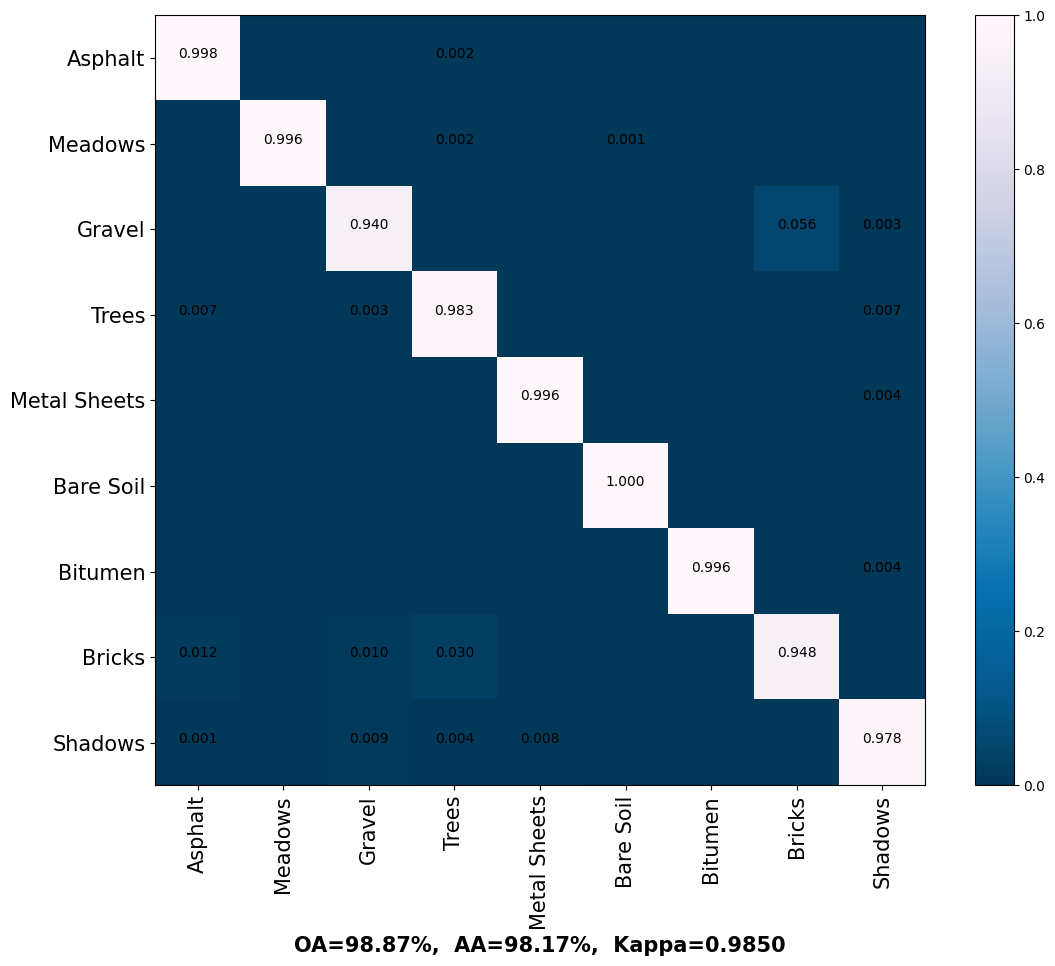

**************************************************
Final result:
OA: 98.87% | AA: 98.17% | Kappa: 0.9850
[0.9975377  0.99644342 0.94020418 0.98267821 0.99620637 1.
 0.9961627  0.94789357 0.97844828]
**************************************************
Parameter:
dataset: Pavia
flag_test: train
mode: CAF
gpu_id: 0
seed: 0
batch_size: 32
patch_size: 13
epoches: 100
learning_rate: 0.0005
gamma: 0.99
weight_decay: 0.001
train_number: 1
train_proportion: 0.02
**************************************************


In [12]:
net.eval()
tar_test, pre_test = auxiliary_test_epoch(net, test_loader)  # 收集所有真实标签和预测标签(np.array)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)

# output classification maps
#pre_u = auxiliary_valid_epoch(net, true_loader)
#prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
#for i in range(total_pos_true.shape[0]):
#    prediction_matrix[total_pos_true[i, 0], total_pos_true[i, 1]] = pre_u[i] + 1
cm = confusion_matrix(tar_test, pre_test)
plot_confusion_matrix(args.dataset, cm, path='./Confusion_Map_HybridSN.pdf')

print("**************************************************")
print("Final result:")
print("OA: {:.2f}% | AA: {:.2f}% | Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print(AA_test)
print("**************************************************")
print("Parameter:")
print_args(vars(args))
print("**************************************************")